<a href="https://colab.research.google.com/github/PhilipRuebeling/master_thesis/blob/main/photonic_devices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}\newcommand{\bra}[1]{\left\langle
{#1}\right|}$$

# Presettings

In [1]:
%pip install fst-pso  # particle swarm optimization

In [2]:
import numpy as np
import fstpso as fp

import matplotlib.pyplot as plt
import scipy.special
import math
import itertools
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.linalg import dft
from scipy.linalg import expm, sinm, cosm
from random import *

# Routines


In [3]:
def adjoint(A) :
    return np.transpose(np.conjugate(A))

In [4]:
def commutator(A, B) :
  return (A @ B - B @ A)

In [5]:
def delta(i, j) :
  return int(i == j)

In [6]:
def pack(parameters_ps, parameters_em, mod_depth) :
    parameters = []
    for k in range(0, n_layers*n_bins) :
        parameters.append(parameters_ps[(k//n_bins)][(k%n_bins)])
    for k in range(0, 2*n_layers*mod_depth) :
        parameters.append(parameters_em[k//(2*mod_depth)][(k%(2*mod_depth))])
    return parameters

In [7]:
def unpack(parameters, mod_depth) :
    parameters_ps = np.zeros(shape=(n_layers, n_bins), dtype='float')
    parameters_em = np.zeros(shape=(n_layers, 2*mod_depth), dtype='float')
    for k in range(0, n_layers*n_bins) :
        parameters_ps[(k//n_bins)][(k%n_bins)] = parameters[k]
    for k in range(0, 2*n_layers*mod_depth) :
        parameters_em[k//(2*mod_depth)][(k%(2*mod_depth))] = parameters[(k + n_bins*n_layers)]
    return [parameters_ps, parameters_em]

In [8]:
def state_to_statistics(state) :
  return [np.abs(state[i])**2 for i in range(0, len(state))]

# Electro-optic modulator (EOM)


[Electro-optic modulator](https://en.wikipedia.org/wiki/Electro-optic_modulator) (EOM) have broad ranges of application in classical and quantum photonics. In our proposal the essential feature that we exploit form EOM's is their ability to deterministically mix frqeuencies.

We may choose to characterize the EOM by it's modulation signal $a(t) = \sum_{k=1}^{f} a_{k}\sin(\Omega_{k} t + \varphi_{k})$. Here we call $f = 1, 2, \dots$ the modulation depth. In this work we will concentrate on single-tone modulation, where $f=1$.

$a^{\dagger}_{r} \rightarrow Sa^{\dagger}_{r}S^{\dagger} = \sum_{q} (-ie^{-i\vartheta})^{q} J_{q}(m)a^{\dagger}_{r+q}$.

In [9]:
# parameters to test the EOM
mod_depth = 1     # modulation depth
a_min = 00.00     # minimal modulation amplitude
a_max = 10.00     # maximal modulation amplitude

n_bins = 4
parameters_test = [2, 0.0]

This defines the unitary in time domain (TD).

In [10]:
def em_unitaryTD(parameters, mod_depth, n_bins) :
    U = np.zeros(shape=(n_bins, n_bins), dtype="complex128")
    amplitude, phase = parameters
    for i in range(0, n_bins):
        U[i][i] += np.exp(1j*(amplitude*np.sin(np.pi*i/n_bins + phase)))
    return U

In [11]:
# testing if unitaryTD returns a unitary matrix
U = np.around(em_unitaryTD(parameters_test, mod_depth, n_bins), decimals=9)
is_unitary = np.allclose(np.eye(n_bins), U @ adjoint(U))
print('em_unitaryTD() returns a unitary matrix: ' + str(is_unitary))

em_unitaryTD() returns a unitary matrix: True


Plotting the modulation signal

In [12]:
def plot_modulation(parameters, mod_depth, n_bins) :
    amplitude, phase = parameters
    t = np.arange(0, 10*n_bins)
    s = np.around(amplitude*np.sin(np.pi*t/n_bins + phase), decimals=9)
    plt.title('modulation signal ot the EOM in TD')
    plt.plot(t/n_bins, s)
    plt.xlabel('time [norm.]')
    plt.ylabel('driving voltage [arb.]')
    plt.show()
    plt.close()
    pass

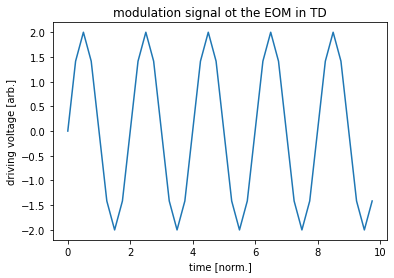

In [13]:
plot_modulation(parameters_test, mod_depth, n_bins)

Here is the corresponding unitary in frequency domain (FD).

In [14]:
def em_unitaryFD(parameters, mod_depth, n_bins) :
    F = dft(n_bins)/np.sqrt(n_bins)
    U = em_unitaryTD(parameters, mod_depth, n_bins)
    return F @ U @ adjoint(F)

In [15]:
# testing if unitaryFD returns a unitary matrix
U = np.around(em_unitaryFD(parameters_test, mod_depth, n_bins), decimals=9)
is_unitary = np.allclose(np.eye(n_bins), U @ adjoint(U))
print('unitaryFD() returns a unitary matrix: ' + str(is_unitary))

unitaryFD() returns a unitary matrix: True


In [16]:
# this function will not return some unitary matrix, 
# since we truncate the hilbert space
def besselFD(parameters, n_bins, f=0.42) :
    U = np.zeros(shape=(n_bins, n_bins), dtype='complex64')
    amplitude, phase = parameters
    for i in range(0, n_bins) :
        for j in range(0, n_bins) :
            if(np.abs(i-j) <= math.ceil(amplitude+2)) :
                U[i][j] = special.jv(i-j, f*amplitude)*(-1j*np.exp(-1j*phase))**(i-j)
    return U

# Phase Shaper (PS)



TODO: explain how the PS works.

In [17]:
n_bins = 4
parameters_test = np.ones(n_bins)

In [18]:
def ps_unitaryFD(parameters, n_bins) :
    U = np.array(np.zeros(shape=(n_bins, n_bins)), dtype='complex64')
    for i in range(0, n_bins):
        U[i][i] = np.exp(1j*parameters[i])
    return U

In [19]:
# testing if unitaryFD returns a unitary matrix
U = np.around(ps_unitaryFD(parameters_test, n_bins), decimals=9)
is_unitary = np.allclose(np.eye(n_bins), U @ adjoint(U))
print('unitaryFD() returns a unitary matrix: ' + str(is_unitary))

unitaryFD() returns a unitary matrix: True


# Benchmarking with classical data

In [20]:
n_bins = 16

In [21]:
def identity() :
  return np.ones(n_bins)/n_bins

In [22]:
def bas22() :
  bas = np.zeros(n_bins)
  bas[0], bas[3], bas[5], bas[10], bas[12], bas[15] = 1, 1, 1, 1, 1, 1
  return bas/6

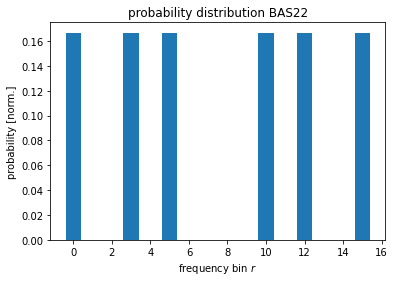

In [23]:
# plot the desired output distribution
fig, ax = plt.subplots()
rects = ax.bar(np.arange(0, n_bins), bas22())
plt.title("probability distribution BAS22")
plt.xlabel('frequency bin $r$')
plt.ylabel('probability [norm.]')
plt.show()

In [24]:
def gaussian(mu=0.0, sigma=0.1) :
  return norm.pdf(np.arange(0, n_bins),n_bins/2-1,2)

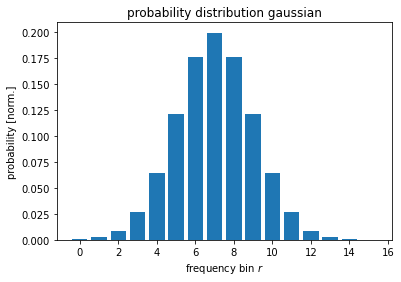

In [25]:
# plot the desired output distribution
fig, ax = plt.subplots()
rects = ax.bar(np.arange(0, n_bins), gaussian())
plt.title("probability distribution gaussian")
plt.xlabel('frequency bin $r$')
plt.ylabel('probability [norm.]')
plt.show()

**Future research** Implement batch sampling. Try to do meaningful simulation tasks such as generative quantum simulation of simple physical models, e.g. estimate the Hamiltonian of a small Ising model via decomposition of the unitary $U(t)^{\dagger}U(t + \epsilon) \approx \mathbb{1} + i\epsilon H + \mathcal{O}(\epsilon^2)$.

# Quantum simulation: XY-model

Which tasks can be solved particularly efficiently on a near-future quantum mechine learning device? 
To partially answer this question, we investigate the ability of our system to simulate non-trivial quantum dynamics. To this end we would like our device to learn the unitary evoultion of a very simple toy model. We choose the integrable XY-model, that consists of a lattice ring with spins ($s = 1/2$) where nearest neigbors do interact. Such a system with $R$ lattice sites may be decribed by a Hamiltonian $H = \sum_{l=1}^{R} (S_{l}^{x}S_{l+1}^{x} + S_{l}^{y}S_{l+1}^{y})$. As usual $S_{l}^{x}, S_{l}^{y}$ denote spin operators on the $l$-th lattice site.


In [26]:
lattice_sites = 4
d = 2**(lattice_sites) # dimension of the Hilbert space.

# Generators of SU(2) 
identity = np.array([[+ 1.0 + 0.0j, + 0.0 + 0.0j], [+ 0.0 + 0.0j, + 1.0 + 0.0j]])
sigma_x  = np.array([[+ 0.0 + 0.0j, + 1.0 + 0.0j], [+ 1.0 + 0.0j, + 0.0 + 0.0j]])
sigma_y  = np.array([[+ 0.0 + 0.0j, + 0.0 - 1.0j], [+ 0.0 + 1.0j, + 0.0 + 0.0j]])
sigma_z  = np.array([[+ 1.0 + 0.0j, + 0.0 + 0.0j], [+ 0.0 + 0.0j, - 1.0 + 0.0j]])

In [27]:
# check if the SU(2) generators fulfill Lie bracket.
is_equal = np.allclose(commutator(sigma_x, sigma_y), 2j*sigma_z)
print("SU(2) Generators fulfill Lie bracket: " + str(is_equal))

SU(2) Generators fulfill Lie bracket: True


In [28]:
def concatenate(operator, i, lattice_sites) :
  operator_order = []
  for j in range(0, lattice_sites) :
    if j == i or j == (i+1)%(lattice_sites) :
      operator_order.append(operator)
    else:
      operator_order.append(identity)
  operator_order.reverse()
  s = operator_order[0]
  for j in range(1, lattice_sites) :
    s = np.kron(operator_order[j], s)
  return s

In [29]:
op1 = np.kron(sigma_x, np.kron(identity, np.kron(identity, sigma_x)))
op2 = concatenate(sigma_x, 3, 4)
np.allclose(op1, op2)

True

In [30]:
# Hamiltonian of the XY-model
def hamiltonian_XY() :
  h = np.zeros(shape=(d, d), dtype="complex64")
  for i in range(0, lattice_sites) :
    h += concatenate(sigma_x, i, lattice_sites) + concatenate(sigma_y, i, lattice_sites)
  return h

In [31]:
# check if Hamiltonian is hermitian
h = hamiltonian_XY()
is_hermitian = np.allclose(h, adjoint(h))
print("Hamiltonian is hermitian: " + str(is_hermitian))

Hamiltonian is hermitian: True


In order to learn the unitary dynamics of the XY model, we have to present some training data to our circuit. To this end a training sample consists of a state $\ket{\psi^{0}_{k}}$ and the corresponding time-evolved state $\ket{\psi^{1}_{k}} = U \ket{\psi^{0}_{k}}$. Our training set consists of $N$ states $\ket{\psi_{k}^{0}} = \sum_{l \in \{ \uparrow, \downarrow \}^R} C^{(k)}_{l} \ket{l}$ with coefficents randomly drawn from a gaussian distribution, i.e. $C^{(k)}_{l} \sim \mathcal{N}(0, 1)$. The states have to be renormalized to unity.

In [39]:
def generate_training_state() :
  random_state = np.zeros(d, dtype="complex64")
  random_state = np.random.normal(0, 1, d) + 1j*np.random.normal(0, 1, d) 
  # normalize the state  
  norm = random_state.dot(adjoint(random_state))                                             
  return random_state/np.sqrt(norm)

In [40]:
# test if the generated random state is normalized
s = generate_training_state()
is_normalized = np.allclose(s.dot(adjoint(s)), 1.0)
print("The generated random state is normalized to one: " + str(is_normalized))

The generated random state is normalized to one: True


In [41]:
# generate a training set.
def generate_training_set(size) :
  U = expm(-1j*hamiltonian_XY()) # unitary time evolution
  training_set = []
  for i in range(0, size) :
    training_state = generate_training_state()
    training_set.append([training_state, U @ training_state])
  return training_set

In [42]:
# test if this works...
training_set = generate_training_set(1)
U = expm(-1j*hamiltonian_XY())
for sample in training_set :
  initial, final = sample
  t = np.allclose(initial, adjoint(U) @ final)
  print(t)

True


# Circuit Optimization

We present two different optimization algorithms to optimize the costfunction. The first one is based on stochastic gradient decent and the second one is based on a gradient free procedure called particle swarm optimization.

Firstly, we present the gradient free approach of particle swarm optimization.

In [ ]:
swarm_size = 100    # number of particles used in the PSO
iterations = 25    # number of iterations in the PSO 

In [ ]:
def bulid_search_space(n_layers, n_bins, mod_depth) :
    phase_range, amplitude_range = [0, 2*np.pi], [a_min, a_max]
    search_space = []
    for i in range(0, n_layers*n_bins) :
        search_space.append(phase_range)
    for i in range(0, n_layers*mod_depth) :
        search_space.append(amplitude_range)
        search_space.append(phase_range)
    return search_space

In [ ]:
def optimize_pso(costfunction, n_layers, n_bins, mod_depth) :
  FP = fp.FuzzyPSO()
  FP.set_search_space(bulid_search_space(n_layers, n_bins, mod_depth))
  FP.set_fitness(costfunction)  
  FP.set_swarm_size(swarm_size)
  best_solution, fitness = FP.solve_with_fstpso(max_iter=iterations)
  return [best_solution, fitness]

**Future work:** Implement gradient based optimization.

# Single Photon Quantum Frequency Processor (QFP-1)

We would like to derive the canonical transformation rule for the annihilation and creation operators in the QFP, i.e. $a_{r} \rightarrow a_{r}' = U a_{r}U^{\dagger} = \sum_{l} V_{rl} a_{l}$ where the unitary transformation $V$ is to be determined.

$\ket{l} = \sqrt{(1 + \delta_{p_{l} q_{l}})^{-1}} a_{p_{l}}^{\dagger}a_{q_{l}}^{\dagger} \ket{vac}$ and the output state is given by $\ket{m} = \sqrt{(1 + \delta_{p_{m} q_{m}})^{-1}} a_{p_{m}}^{\dagger}a_{q_{m}}^{\dagger} \ket{vac}$

The transfer matrix can be written as $W_{lm} = \bra{l} m \rangle = \sum_{} \frac{V_{} V_{}}{\sqrt{(1 + \delta_{})(1 + \delta_{})}}$

The density matrix transforms as $\rho$

In [43]:
n_layers, n_bins = 4, 16  # defines the architecture of the QFP

In [44]:
d_hilbert = n_bins  # dimension of the hilbert space for 1 photon

In [45]:
# input density matrix
def density_operator_input() :
  density_operator = np.zeros(shape=(d_hilbert, d_hilbert), dtype="complex64")
  # specific input
  state = np.ones(d_hilbert)/np.sqrt(d_hilbert)
  density_operator = np.outer(state, state)
  return density_operator

In [46]:
# testing density matrix input
input = density_operator_input()

# normalized?
is_normalized = np.allclose(np.trace(input), 1.0)
print("the density operator is normalized to one: " + str(is_normalized))

# pure state?
is_pure_state = np.allclose(np.trace(input @ input), 1.0)
print("the density operator is pure: " + str(is_pure_state))

the density operator is normalized to one: True
the density operator is pure: True


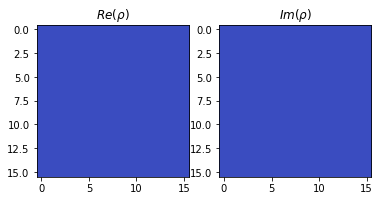

In [47]:
# plot the input density matrix
plt.subplot(121)
plt.imshow(np.real(input), cmap='coolwarm')
plt.title("$Re(\\rho)$")
plt.subplot(122)
plt.imshow(np.imag(input), cmap='coolwarm')
plt.title("$Im(\\rho)$")
plt.show()

In [48]:
def unitaryV(parameters_ps, parameters_em) :
    V = np.eye(n_bins, dtype='complex64')
    for layer in range(0, n_layers) :
        U_em = em_unitaryFD(parameters_em[layer], mod_depth, n_bins)
        U_ps = ps_unitaryFD(parameters_ps[layer], n_bins)
        V = V @ U_ps @ U_em
    return V

In [49]:
# one photon case
def transfer_one_photon(parameters) :
  W = np.zeros(shape=(d_hilbert, d_hilbert), dtype='complex64')
  parameters_ps, parameters_em = unpack(parameters, mod_depth)
  V = unitaryV(parameters_ps, parameters_em)
  for i in range(0, d_hilbert) :
    for j in range(0, d_hilbert) :
      W[i][j] = V[i][j]
  return W

In [50]:
# output density matrix
def density_operator_output(parameters) :
  W = transfer_one_photon(parameters)
  return W @ density_operator_input() @ adjoint(W)

In [51]:
def costfunction(parameters) :
  cost = 0
  actual = np.real(density_operator_output(parameters))
  target = gaussian()
  for i in range(0, n_bins) :
    cost += (actual[i][i] - target[i])**2
  return cost

In [ ]:
optimized_parameters = optimize_pso(costfunction, n_layers, n_bins, mod_depth)

In [ ]:
# testing density matrix output
output = density_operator_output(optimized_parameters[0].X)

# normalized?
is_normalized = np.allclose(np.trace(output), 1.0)
print("the density operator is normalized to one: " + str(is_normalized))

# pure state?
is_pure_state = np.allclose(np.trace(output @ output), 1.0)
print("the density operator is pure: " + str(is_pure_state))

In [ ]:
# plot the output density matrix
plt.subplot(121)
plt.imshow(np.real(output), cmap='coolwarm')
plt.title("$Re(\\rho)$")
plt.subplot(122)
plt.imshow(np.imag(output), cmap='coolwarm')
plt.title("$Im(\\rho)$")
plt.show()

$\rho = Re(\rho) + iIm(\rho)$

In [ ]:
# plotting the statistics
fig, ax = plt.subplots()
rects = ax.bar(np.arange(0, n_bins), [np.real(output[i][i]) for i in range(0, n_bins)])
plt.title("intensity output distribtion of the QFP")
plt.xlabel('frequency bin $r$')
plt.ylabel('intensity $|\\alpha_{r}|^2$ [norm.]')
plt.show()

Quantum simulation with the one photon QFP

In [52]:
# input density matrix
def density_operator_input(state) :
  density_operator = np.zeros(shape=(d_hilbert, d_hilbert), dtype="complex64")
  # specific input
  density_operator = np.outer(state, state)
  return density_operator

In [54]:
# output density matrix
def density_operator_output(parameters, state) :
  W = transfer_one_photon(parameters)
  return W @ density_operator_input(state) @ adjoint(W)

In [56]:
batch = generate_training_set(50)

In [57]:
# costfunction
def costfunction(parameters, batch=batch) :
  cost = 0
  for sample in batch:
    initial = sample[0]
    actual = density_operator_output(parameters, initial)
    target = np.outer(sample[1], adjoint(sample[1]))
    cost += np.linalg.norm(actual - target)
  return cost

In [58]:
optimized_parameters = optimize_pso(costfunction, n_layers, n_bins, mod_depth)

NameError: ignored

# Twin Photon Quantum Frequency Processor (QFP-2)

In [ ]:
n_layers, n_bins = 2, 32  # defines the architecture of the QFP

In [ ]:
d_hilbert = int(n_bins * (n_bins - 1)/2) # dimension of the hilbert space for two photons

In [ ]:
# input density matrix
def density_operator_input() :
  density_operator = np.zeros(shape=(d_hilbert, d_hilbert), dtype="complex64")
  # specific input
  state = np.ones(d_hilbert)/np.sqrt(d_hilbert)
  density_operator = np.outer(state, state)
  return density_operator

In [ ]:
# testing density matrix input
input = density_operator_input()

# normalized?
is_normalized = np.allclose(np.trace(input), 1.0)
print("the density operator is normalized to one: " + str(is_normalized))

# pure state?
is_pure_state = np.allclose(np.trace(input @ input), 1.0)
print("the density operator is pure: " + str(is_pure_state))

In [ ]:
# plot the input density matrix
plt.subplot(121)
plt.imshow(np.real(input), cmap='coolwarm')
plt.title("$Re(\\rho)$")
plt.subplot(122)
plt.imshow(np.imag(input), cmap='coolwarm')
plt.title("$Im(\\rho)$")
plt.show()

In [ ]:
# two photon case
def transfer_two_photon(parameters) :
  W = np.zeros(shape=(n_bins, n_bins), dtype='complex64')
  parameters_ps, parameters_em = unpack(parameters, mod_depth)
  V = unitaryV(parameters_ps, parameters_em)
  for l in range(0, n_bins) :
    r1, r2 = labelMapping(l)
    for m in range(0, n_bins) :
      q1, q2 = labelMapping(m)
      permutations = getPermutations([q1, q2])
      for perm in permutations:
        a, b = perm
        W[l][m]+=1.0/(np.sqrt((1 + delta(r1, r2))*(1 + delta(q1, q2))))*V[r1][a]*V[r2][b]
  return W

It is well known from the standard beam splitter interference experiments performed by [Hong, Ou and Mandel](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect) (1987) that phenomena of quantum interference only arise for indistinguishable bosons. When photons become distingushable in any DoF (i.e. have different quantum numbers) they no longer show such interesting properties. Thus in the given context we might investigate the role of the quantum interference a little bit closer. For instance we could ask what happens, if the photons in a QFP become distinguishable, e.g. by their polarization. Does that have any major consequences on the deep learning performance of the device? 

To investigate such questions, suppose we are able to prepare a quantum state of two photons which have same different polarization, but have the same properties in every other degree of freedom. In the frequency bin setup we are able to adiabatically tune the quantum interference by adjusting the relativ polarisation of the photons. A state where the photons can be perfectly distinguished may be written as $\ket{dist} = a^{\dagger}_{rV} a^{\dagger}_{rH} \ket{vac}$ where $H,V$ denote horizontal and vertical polarisation, respectivley.

**Further research:** Besides one and two photon inputs, we might ask what happens if we feed the QFP with other highly non-classical states of ligth. Such states might GHZ, noon states, squeezed states, ...

# Classical Frequency Processor (CFP)

Now, that we have considered the quantum case, we shall examine a classical frequency processor (CFP). Such a device is very similar to the QFP, the only difference being that it operates with classical states of light and usually at higher intensities. Just like in the quantum case we can have "classical" interference between the different frequency bins which is due to the frequncy mixing of the EOM. Due to this observation the following fundamental question arises: can we perform certain deep learning tasks on a CFP just as good as on a QFP? 

Of course it is possible to describe a CFP with classical fields. Here we choose the same quantum framework as we previously encoutered for the QFP to analyse the CFP. This is possbile if we choose as input states of light that are sufficiently "classical" with relativley high intensities. Thus coherent states are a quite natural choice, as they are essentially laser light. 

Let's get somewhat techncial. A coherent state $\ket{\alpha} = D(\alpha)\ket{vac}$ can be described by applying the displacement operator to the vacuum. The displacement operator is defined by $D(\alpha) = \exp \big(\sum_{r=0}^{M-1} \alpha_{r} a^{\dagger}_{r}+ \alpha_{r}^{*} a_{r} \big)$. It's a reasonable choice to feed the CFP with some "classical" input state, where each frequency bin is uniformly populated by the intensity $I_{r} \propto |\alpha_{r}|^{2}$. Formally, this input state may be written as a collection of coherent states $\ket{in} = \ket{\alpha}_{0} \otimes \dots \otimes \ket{\alpha}_{M-1}$, with uniform $\alpha \in \mathbb{C}$ for all frequency bins.

To determine the output state of the CFP we have to revisit the tranfsormation rules for anihilation and creation operators. Previously we obtained the canonical transformation rule $a_{r} \rightarrow a_{r}' = \sum_{l} V_{rl} a_{l}$ for a single frequency bin in the QFP. Results for the CFP can be obtained in strict analogy by subsitution of the transformed operators into the displacement operator for coherent states $D(\alpha) \rightarrow D(\alpha') = \exp(\sum_{r}\alpha_{r}' a_{r} + \text{h.c.})$ we get some collection of coherent states again. The complex parameters of the resulting coherent states are given by $\alpha_{r}' = \sum_{l} V_{rl} \alpha_{l}$. Form this we can obatin the ouput intensity distribution by $I_{r}' \propto |\alpha_{r}'|^{2}$.

In [ ]:
n_layers, n_bins = 2, 16  # defines the architecture of the CFP
mod_depth = 1

In [ ]:
def unitaryV(parameters_ps, parameters_em) :
    V = np.eye(n_bins, dtype='complex64')
    for layer in range(0, n_layers) :
        U_em = em_unitaryFD(parameters_em[layer], mod_depth, n_bins)
        U_ps = ps_unitaryFD(parameters_ps[layer], n_bins)
        V = V @ U_ps @ U_em
    return V

In [ ]:
# uniform intensity distribution
def classical_input(n_bins) :
  input_state = np.ones(n_bins)
  input_state /= np.sqrt(sum(input_state))
  return input_state

In [ ]:
# testing if input distribution is normalized to 1
input_distribution = state_to_statistics(classical_input(n_bins))
is_normalized = np.allclose(sum(input_distribution), 1)
print('classical_input_distribution() returns a normalized distribution: ' + str(is_normalized))

In [ ]:
# plotting the input intensities.
fig, ax = plt.subplots()
rects = ax.bar(np.arange(0, n_bins), input_distribution)
plt.title("intensity input distribtion of the CFP")
plt.xlabel('frequency bin $r$')
plt.ylabel('intensity $|\\alpha_{r}|^2$ [norm.]')
plt.show()

In [ ]:
def classical_output(parameters, mod_depth, n_bins) :
  parameters_ps, parameters_em = unpack(parameters, mod_depth)
  V = unitaryV(parameters_ps, parameters_em)
  output_state = V @ classical_input(n_bins)
  return output_state

In [ ]:
def costfunction(parameters) :
  cost = 0
  actual = state_to_statistics(classical_output(parameters, mod_depth, n_bins))
  target = gaussian()
  for i in range(0, n_bins) :
    cost += (actual[i] - target[i])**2
  return cost

In [ ]:
optimized_parameters = optimize_pso(costfunction, n_layers, n_bins, mod_depth)

In [ ]:
# testing if the output distribution is normalized to 1
output_distribution = state_to_statistics(classical_output(optimized_parameters[0].X, mod_depth, n_bins))
is_normalized = np.allclose(sum(output_distribution), 1)
print('classical_input_distribution() returns a normalized distribution: ' + str(is_normalized))

In [ ]:
# plotting the output intensities.
fig, ax = plt.subplots()
rects = ax.bar(np.arange(0, n_bins), output_distribution)
plt.title("intensity output distribtion of the CFP")
plt.xlabel('frequency bin $r$')
plt.ylabel('intensity $|\\alpha_{r}|^2$ [norm.]')
plt.show()


**Future research:** Yet, we have considered states at the border between quantum and classical regime, i.e. coherent states. What happens if we feed the CFP with other "classical" states of light that show lower degrees of coherence? This question seems especially important if we want to quantify the robustness of our device against thermal noise and decoherence. Future investigation could involve mixtures of coherent states $\rho = \frac{1}{2}(\ket{\alpha} \bra{\alpha} + \ket{\beta} \bra{\beta})$ ($\alpha \neq \beta$) as well as partially thermalized coherent states.